# Week 5 - AB Testing

Google Analytics provides APIs for others to retrieve data in a flexible way. The flexible report generation is based on the definition of **dimensions** and **metrics**.
More information about dimensions and metrics can be found [here](https://developers.google.com/analytics/devguides/reporting/data/v1/api-schema). More information about how to generate reports can be found [here](https://developers.google.com/analytics/devguides/reporting/data/v1/basics#python_3).

# 1. Import Packages

In [11]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (
    DateRange,
    Dimension,
    Metric,
    RunReportRequest,
    Filter,
    FilterExpression,
)
import os
import pandas as pd
import json
import scipy.stats as st 
import numpy as np

!pip3 install pingouin
from pingouin import ttest

# 2 Report Generation
Below is a function ```sample_run_report```. The parameter is the property id, and the dimensions, metrics, and date_ranges can be specified below.

## 2.1 Conversion Report
The report below collects collects event sessions by experimental group

In [12]:
def sample_run_report_conversion(property_id="424145747"):
    """Runs a simple report on a Google Analytics 4 property."""
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'apt-port-251804-905e08b9e9e3.json'
    client = BetaAnalyticsDataClient()
    request = RunReportRequest(
        property="properties/{}".format(property_id),
        dimensions=[Dimension(name="campaignName"),Dimension(name="eventName"),Dimension(name="date")], #Dimension(name="sessionCampaignName"),
        metrics=[Metric(name="sessions")],
        date_ranges=[DateRange(start_date="2024-01-01", end_date="today")],
         dimension_filter=FilterExpression(
            filter=Filter(
                field_name="campaignName",
                in_list_filter=Filter.InListFilter(
                    values=[
                        "main",
                        "experiment"
                    ]
                ),
            )
        ),
    )
    response = client.run_report(request)
    return response

## 2.2 Session Report
The report below shows all experimental sessions:

In [13]:
def sample_run_report_session(property_id="424145747"):
    """Runs a simple report on a Google Analytics 4 property."""
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'apt-port-251804-905e08b9e9e3.json'
    client = BetaAnalyticsDataClient()
    request = RunReportRequest(
        property="properties/{}".format(property_id),
        dimensions=[Dimension(name="customEvent:Branch"),Dimension(name="date")], #Dimension(name="sessionCampaignName"),
        metrics=[Metric(name="sessions")],
        date_ranges=[DateRange(start_date="2024-01-01", end_date="today")],
          dimension_filter=FilterExpression(
            filter=Filter(
                field_name="customEvent:Branch",
                in_list_filter=Filter.InListFilter(
                    values=[
                        "main",
                        "experiment"
                    ]
                ),
            )
        ),
    )
    response = client.run_report(request)
    return response

# 3 Data Conversion
The default output is json, which we can transform into a dataframe using the following function **response_to_df**.

In [14]:
def response_to_df(response):
    columns = []
    rows = []
     
    for col in response.dimension_headers:
        columns.append(col.name)
    for col in response.metric_headers:
        columns.append(col.name)
     
    for row_data in response.rows:
        row = []
        for val in row_data.dimension_values:
            row.append(val.value)
        for val in row_data.metric_values:
            row.append(val.value)
        rows.append(row)
    return pd.DataFrame(rows, columns=columns)


# 4 Data Collection Pipeline

## 4.1 Conversion Data
The code below shows the main pipeline of this task.

In [15]:
response=sample_run_report_conversion(property_id="424145747")
df1=response_to_df(response)
print(df1)

# change the column name from  campaignName to customEvent:Branch
df1.rename(columns={'campaignName': 'customEvent:Branch'}, inplace=True)
# Only look at submit
df1 = df1[df1['eventName'] == 'submit']

   campaignName eventName      date sessions
0    experiment    submit  20240311        6
1    experiment     again  20240311        4
2    experiment    submit  20240305        3
3          main    submit  20240322        3
4    experiment     again  20240305        2
5    experiment    submit  20240309        2
6    experiment    submit  20240310        2
7    experiment    submit  20240322        2
8          main     again  20240305        2
9          main    submit  20240305        2
10         main    submit  20240404        2
11   experiment     again  20240309        1
12   experiment     again  20240404        1
13   experiment    submit  20240404        1
14         main     again  20240309        1
15         main     again  20240404        1
16         main    submit  20240309        1


## 4.2 Session Data

In [16]:
response=sample_run_report_session(property_id="424145747")
df2=response_to_df(response)
print(df2)

   customEvent:Branch      date sessions
0                main  20240318       20
1          experiment  20240311       14
2                main  20240311       12
3          experiment  20240305        6
4                main  20240322        6
5                main  20240305        5
6          experiment  20240310        4
7                main  20240312        4
8                main  20240313        4
9                main  20240401        4
10               main  20240304        3
11               main  20240323        3
12               main  20240324        3
13               main  20240328        3
14               main  20240404        3
15         experiment  20240304        2
16         experiment  20240306        2
17         experiment  20240309        2
18         experiment  20240312        2
19               main  20240306        2
20               main  20240310        2
21               main  20240316        2
22               main  20240317        2
23              

# 5. Hypothesis Testing 

## 5.1 Prepare Data
To combine the two datasets, we used a merge function:

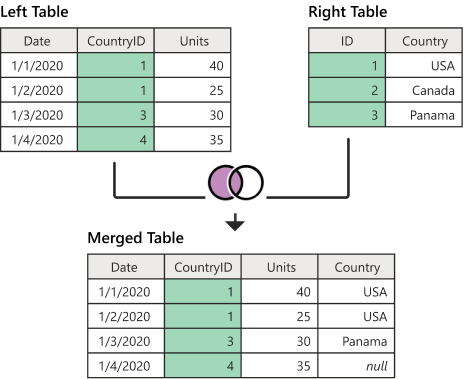

In [17]:


# the merge function can combine two dataframes based on keywords. A left 
merged_df = pd.merge(df2, df1, on=['date', 'customEvent:Branch'], how='left')

merged_df.fillna(0, inplace=True)

# calculate the ratio between submission sessions and all sessions per day.
merged_df['submit_session_ratio_per_day']=merged_df['sessions_y'].astype(int)/merged_df['sessions_x'].astype(int)

# extract data for control
control = merged_df[merged_df['customEvent:Branch'] == 'main']['submit_session_ratio_per_day']
# extract data for treatment 
treatment =merged_df[merged_df['customEvent:Branch'] == 'experiment']['submit_session_ratio_per_day']


## 5.2 Student T-Test 
This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

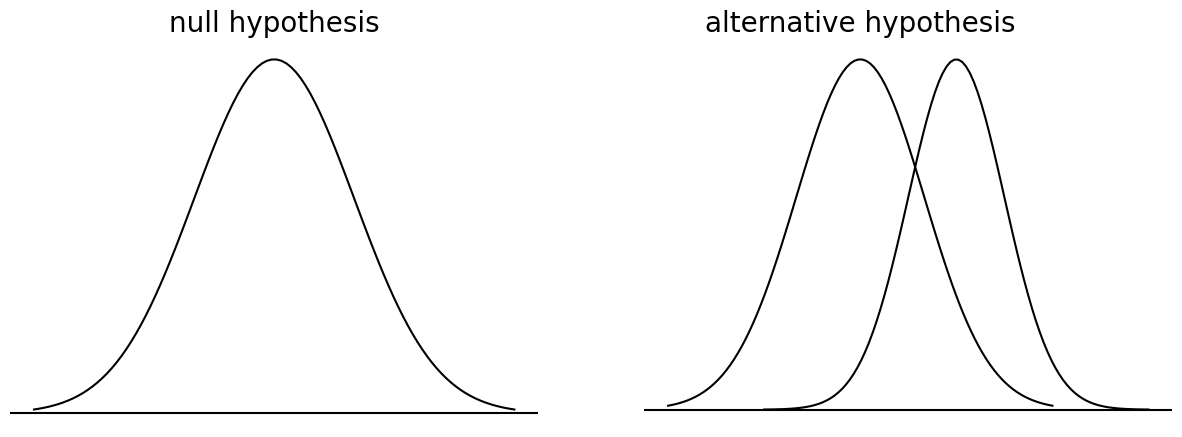

In [18]:
# Calculate sample means for both groups
mean_control = np.mean(control)
mean_treatment = np.mean(treatment)

# Calculate sample standard deviations for both groups
std_control = np.std(control)
std_treatment = np.std(treatment)


t_stat, p_value = st.ttest_ind(treatment, control)

# Define significance level
alpha = 0.05

# Check if the difference is statistically significant
if p_value < alpha:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

# Output the results
print(f"Control Group Mean: {mean_control}")
print(f"Treatment Group Mean: {mean_treatment}")
print(f"P-Value: {p_value}")

The difference is statistically significant.
Control Group Mean: 0.09166666666666666
Treatment Group Mean: 0.4285714285714286
P-Value: 0.006314711993644838


In [19]:
# We could use a different package to perform student t-test:
from pingouin import ttest

ttest(treatment,control,correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.911129,34,two-sided,0.006315,"[0.1, 0.57]",1.167048,6.988,0.80732


## 5.3 Welch T-Test
The biggest problem with using the Student test in practice is the third assumption listed in the previous section: it assumes that both groups have the same standard deviation. This is rarely true in real life: if two samples don’t have the same means, why should we expect them to have the same standard deviation? There’s really no reason to expect this assumption to be true. 


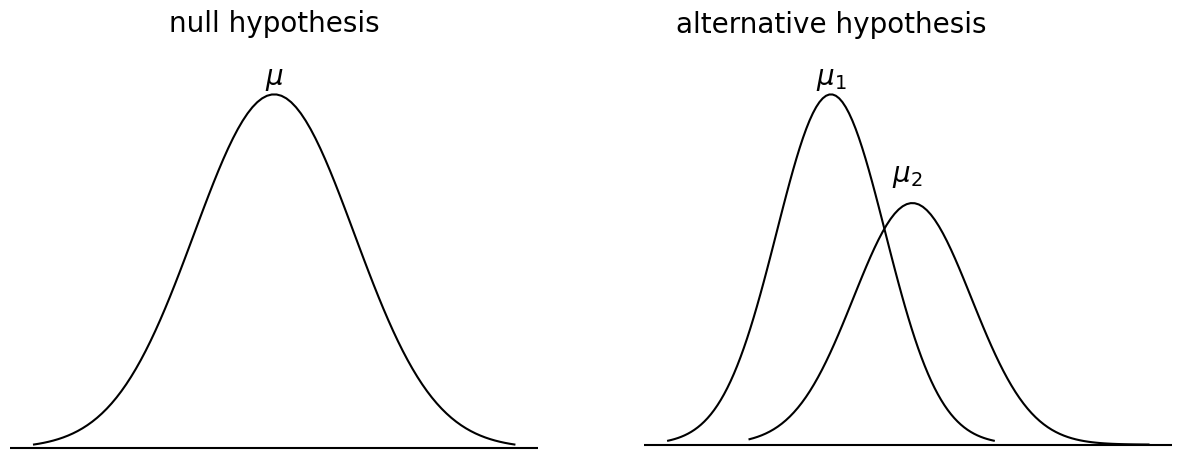
The Welch T-Test does not rely on this assumption, and has a different way of calculating standard error and degree of freedom. 

In [13]:
from pingouin import ttest

ttest(treatment,control,correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.182664,8.429788,two-sided,0.058917,"[-0.02, 0.69]",1.167048,2.001,0.80732
